In [1]:

#!/usr/bin/env python3

import sys, getopt
import numpy as np
from math import *
import os
import subprocess
import shlex
import regex as re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

%matplotlib widget

def intersection_element(sets, threshold = 0.95):		
    c = Counter()
    for s in sets:
        for elem in s:
            c[elem] += 1
    return [k for k, v in c.items() if v >= len(sets) * threshold]

def sort_lists(A, B, k = 3):
	# Create a list of tuples where each tuple contains an element from A and its index in B
	zipped = list(zip(A, B, range(len(B))))

	# Sort the list of tuples based on the values in B
	zipped.sort(key=lambda x: x[1])

	# Create two separate lists from the sorted list of tuples
	sorted_A = [x[0] for x in zipped]
	sorted_B = [x[1] for x in zipped]
	indices = [x[2] for x in zipped]

	return sorted_A[:k], sorted_B[:k], indices[:k]

def sort_lists_eps(A, B, eps = 0.7):
	# Create a list of tuples where each tuple contains an element from A and its index in B
	zipped = list(zip(A, B, range(len(B))))

	# Sort the list of tuples based on the values in B
	zipped.sort(key=lambda x: x[1])

	t_best = zipped[0][1]
	t_worst = zipped[-1][1]

	threshold = t_best + eps*(t_worst - t_best)

	# Create two separate lists from the sorted list of tuples
	sorted_A = [x[0] for x in zipped if x[1] if x[1] <= threshold]
	sorted_B = [(x[1] - t_best)/(t_worst - t_best) for x in zipped if x[1]]

	return sorted_A, sorted_B

def match_pattern(pattern, line):
	m = []
	matches = re.findall(pattern, line)
	for match in matches:
		m.append(float(match[2:]))
	return m

def average_columns(data):
    # Transpose the 2D list to get the columns as rows
    transposed_data = [[row[i] for row in data] for i in range(len(data[0]))]

    # Calculate the sum of each column and divide by the number of rows
    result = [sum(column) / len(data) for column in transposed_data]

    return result

def intersection_confidence(final_m_values, final_time_values, k_values, threshold_values, k_method = True):
	for k in k_values:
		final_set = set()
		for c in range(len(final_m_values)):
			if k_method:
				final_m = sort_lists(final_m_values[c], final_time_values[c], k)
			else:
				final_m = sort_lists_eps(final_m_values[c], final_time_values[c], k)[0]
			if c == len(final_m_values) - 1:
				print("Final m values for square:", final_m)
			final_set.add(frozenset(final_m))

		for l in threshold_values:
			values = intersection_element(final_set, l)
			if len(values) != 0:
				if k_method:
					print("Common intersection of m values with threshold " + str(l) + " and k values " + str(k), values)
				else:
					print("Common intersection of m values with threshold " + str(l) + " and eps values " + str(k), values)
					
def optimal_values(final_m_values, final_time_values, point_to_compare = 0):
	final_set = []
	for c in range(len(final_m_values)):
		final_m = sort_lists(final_m_values[c], final_time_values[c], 1)[0]
		final_set.append(final_m - point_to_compare)
	return final_set

def shared_factors(num1, num2):
    # Find the smaller of the two numbers
    if num1 < num2:
        smaller = num1
    else:
        smaller = num2

    # Initialize a variable to keep track of the number of shared factors
    shared = 0

    # Check each number from 1 to the smaller number
    for i in range(1, smaller + 1):
        # If i is a factor of both num1 and num2, increment the shared variable
        if num1 % i == 0 and num2 % i == 0:
            shared += 1

    # Return the number of shared factors
    return shared


def plot2d(x,y,thread, threshold, point_to_compare):
	plt.title("Common intersection with threshold {} and point {}".format(threshold, point_to_compare))
	plt.xlabel("Ly values")
	plt.ylabel("Difference between the optimal value and the point to compare")
	plt.plot(x, y, label = "Thread " + str(thread))
	plt.savefig("threshold_" + str(threshold) + "_point_" + str(point_to_compare) + ".png")
	plt.show()

def plot(x,y,z,thread, plot_type = "3d"):
	# Create the figure and 3D axis
	fig = plt.figure(figsize = (10,10))
	if plot_type == "3d":
		ax = fig.add_subplot(111, projection='3d')
	else:
		ax = fig.add_subplot(111)

	# Plot the data
	colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'][:len(x)]

	optimal_t = []
	optimal_y = []
	for i in range(len(x)):
		max_time = float(1e5)
		max_m = 0
		for j in range(len(y[i])):
			if max_time > z[i][j]:
				max_m = y[i][j]
				max_time = z[i][j]
		optimal_t.append(max_time)
		optimal_y.append(max_m)
		
	print("Max upper bound on time:", max(optimal_t),"\n")
	print("Min upper bound on time:", min(optimal_t),"\n")
	print("Average upper bound on time:", sum(optimal_t)/len(optimal_t),"\n")

	print("Max m value:", max(optimal_y),"\n")
	print("Min m value:", min(optimal_y),"\n")
	print("Average m value:", sum(optimal_y)/len(optimal_y),"\n")

	if plot_type == "3d":
	
		for i in range(len(x)):
			ax.scatter(x[i], y[i], z[i], c=colors[i%8], marker='o')
			ax.text(x[i], optimal_y[i], optimal_t[i], "OP", size=10, zorder=1, color='k')
	
		#cb = plt.colorbar(ax1, pad=0.2)

		# Set axis labels
		ax.set_title('Time taken vs Ly and m values')
		#ax.set_xticks(x)
		ax.set_ylabel('m values')
		ax.set_zlabel('time taken values')
		ax.set_xlabel('Ly values')
	else:
		plt.scatter(x, optimal_y)
		plt.title('Optimal m values vs Ly values')
		plt.ylabel('m values')
		plt.xlabel('Ly values')
		#plt.yticks(optimal_y)

	# Show the plot
	#plt.savefig("test.png")
	plt.show()

# Function to generate multiples of the form 2^a * 3^b * 5^c * 7^d
def generate_multiples(a_max, b_max, c_max, d_max, bound):
    multiples = set()
    for a in range(a_max + 1):
        for b in range(b_max + 1):
            for c in range(c_max + 1):
                for d in range(d_max + 1):
                    multiple = 2**a * 3**b * 5**c * 7**d
                    if multiple <= bound:
                        multiples.add(multiple)
    return list(multiples)

In [15]:
lx_values = sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = 2048))[49:50]
print(lx_values)

[120]


# Main Results

In [16]:

thread = [[],[],[],[],[],[],[],[]]
lx_values = sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = 2048))[49:50]
print(lx_values)
#lx_values = [j for j in range(2, 10)]
final_m_values = []
final_time_values = []
t_array = [1]
random_averages = 2

for l in lx_values:
	print("Lx=", l, end="\n")
	for thread in t_array:
		final_m_values = []
		final_time_values = []
		final_set = set()
		ly_values = sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = l))[1:]
		for i in ly_values:
			print("Thread ", thread, ": ", end=" ")
			print("Ly=", i, end="\n")
			averaged_columns_m = []
			averaged_columns_time = []
			for k in range(random_averages):
				string = "./hybridconv2 -Lx=" + str(l) + " -Ly=" + str(i) + " -Mx=" + str(2*l) +" -My=" + str(2*i) + " -t -R -T=" + str(thread)
				print(string)
				cmd = subprocess.run(shlex.split(string), capture_output=True, text=True)
				string = cmd.stdout
				pattern = "m="
				matches = re.finditer(pattern, string)

				for match in matches:
					# Get the starting index of the match

					start = match.start()
					if int(start) < 100:
						# Get the line number by counting the number of newline characters before the match

						line_num = string[:start].count("\n") + 1
						line_start = string.rfind("\n", 0, start) + 1
						line_end = string.find("Optimal time: ", start)
						line = string[line_start:line_end]
 						# Extract the values as a float and append to a list
						m_values = match_pattern("m=\d+", line)
						time_values = match_pattern("t=[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?", line)
						break
				
				averaged_columns_m.append(m_values[:7])
				averaged_columns_time.append(time_values[:7])
			final_m_values.append(average_columns(averaged_columns_m)[:7])
			final_time_values.append(average_columns(averaged_columns_time)[:7])
		print("-------------------------------------------------------")
		#plot(ly_values,final_m_values,final_time_values,thread)
		final_m_values = np.array(final_m_values)
		#print(final_m_values)
		final_time_values = np.array(final_time_values)
		#print(final_time_values)
		np.save("/home/rjoseph1/fftw++/tests/trial_runs/new_runs_final/final_square_m_values" + str(l), final_m_values)
		np.save("/home/rjoseph1/fftw++/tests/trial_runs/new_runs_final/final_square_time_values" + str(l), final_time_values)

[120]
Lx= 120
Thread  1 :  Ly= 2
./hybridconv2 -Lx=120 -Ly=2 -Mx=240 -My=4 -t -R -T=1
./hybridconv2 -Lx=120 -Ly=2 -Mx=240 -My=4 -t -R -T=1
Thread  1 :  Ly= 3
./hybridconv2 -Lx=120 -Ly=3 -Mx=240 -My=6 -t -R -T=1
./hybridconv2 -Lx=120 -Ly=3 -Mx=240 -My=6 -t -R -T=1
Thread  1 :  Ly= 4
./hybridconv2 -Lx=120 -Ly=4 -Mx=240 -My=8 -t -R -T=1
./hybridconv2 -Lx=120 -Ly=4 -Mx=240 -My=8 -t -R -T=1
Thread  1 :  Ly= 5
./hybridconv2 -Lx=120 -Ly=5 -Mx=240 -My=10 -t -R -T=1
./hybridconv2 -Lx=120 -Ly=5 -Mx=240 -My=10 -t -R -T=1
Thread  1 :  Ly= 6
./hybridconv2 -Lx=120 -Ly=6 -Mx=240 -My=12 -t -R -T=1
./hybridconv2 -Lx=120 -Ly=6 -Mx=240 -My=12 -t -R -T=1
Thread  1 :  Ly= 7
./hybridconv2 -Lx=120 -Ly=7 -Mx=240 -My=14 -t -R -T=1
./hybridconv2 -Lx=120 -Ly=7 -Mx=240 -My=14 -t -R -T=1
Thread  1 :  Ly= 8
./hybridconv2 -Lx=120 -Ly=8 -Mx=240 -My=16 -t -R -T=1
./hybridconv2 -Lx=120 -Ly=8 -Mx=240 -My=16 -t -R -T=1
Thread  1 :  Ly= 9
./hybridconv2 -Lx=120 -Ly=9 -Mx=240 -My=18 -t -R -T=1
./hybridconv2 -Lx=120 -Ly=9 -M

In [ ]:
final_m_values = np.load("final_m_values.npy")
final_time_values = np.load("final_time_values.npy")

# Best m values and how often they appear
z = optimal_values(final_m_values, final_time_values, 0)
r = Counter(z)

print("Optimal values for m:", r)

# Plot Ly_values vs m_values against the optimal 2d square
ly_values = [i for i in range(2,513)]
#plot(ly_values,final_m_values,final_time_values,thread,"2d")

plot(ly_values[400:], final_m_values[400:], final_time_values, thread=1, plot_type="2d")

# Final statistics
print("Final statistics:")

# final statistics for k = 3,5,7
#intersection_confidence(final_m_values, final_time_values, [3,5,7], [0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9], True)

# final statistcis for eps = 0.1,0.5,1
intersection_confidence(final_m_values, final_time_values, [0.1,0.2,0.5,0.6,0.9], [0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9], False)

In [48]:
e = "t=2.95e-07"
matches = re.findall("t=[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?", e)
print(float(matches[0][2:]))

2.95e-07


In [ ]:
for i in [2,4,8,16,32,64,128,256]:
	print("Ly value = ", i)
	m, time = sort_lists_eps(final_m_values[i-1], final_time_values[i-1], 0.1)
	print("m values: ", m)
	print("time values: ", time)
	print("\n")

# Square optimal Values

In [18]:
final_square_m = np.load("final_square_m_values.npy")
final_square_time = np.load("final_square_time_values.npy")
final_square_m

array([[1.600e+01, 8.000e+00, 2.700e+01, 2.500e+01, 1.600e+01, 9.000e+00,
        8.000e+00, 7.000e+00, 5.000e+00, 4.000e+00],
       [3.200e+01, 1.600e+01, 2.700e+01, 2.500e+01, 1.600e+01, 9.000e+00,
        8.000e+00, 7.000e+00, 5.000e+00, 4.000e+00],
       [1.280e+02, 6.400e+01, 3.200e+01, 2.700e+01, 2.500e+01, 1.600e+01,
        9.000e+00, 8.000e+00, 4.000e+00, 2.000e+00],
       [2.560e+02, 1.280e+02, 6.400e+01, 4.900e+01, 3.200e+01, 2.700e+01,
        1.600e+01, 8.000e+00, 4.000e+00, 2.000e+00],
       [5.120e+02, 2.560e+02, 1.280e+02, 1.250e+02, 8.100e+01, 6.400e+01,
        3.200e+01, 1.600e+01, 8.000e+00, 4.000e+00],
       [1.024e+03, 5.120e+02, 2.560e+02, 2.430e+02, 1.280e+02, 1.250e+02,
        8.100e+01, 6.400e+01, 3.200e+01, 1.600e+01],
       [2.048e+03, 1.024e+03, 5.120e+02, 3.430e+02, 2.560e+02, 2.430e+02,
        1.280e+02, 1.250e+02, 6.400e+01, 3.200e+01]])

Square size =  32
30 Square best values [48.0] [1.08875]
96 rectangle best values [32.0] [1.1764999999999999]
----------------------------------------------------
Square size =  35
21 Square best values [20.0] [2.2097499999999997]
96 rectangle best values [20.0] [2.21675]
----------------------------------------------------
Square size =  36
27 Square best values [20.0] [2.22075]
96 rectangle best values [20.0] [2.26175]
----------------------------------------------------
Square size =  40
21 Square best values [20.0] [2.325]
96 rectangle best values [20.0] [2.3585000000000003]
----------------------------------------------------
Square size =  42
25 Square best values [25.0] [2.70425]
96 rectangle best values [25.0] [2.9777500000000003]
----------------------------------------------------
Square size =  45
21 Square best values [25.0] [2.7865]
96 rectangle best values [93.0] [3.2350000000000003]
----------------------------------------------------
Square size =  48
7 Square best valu

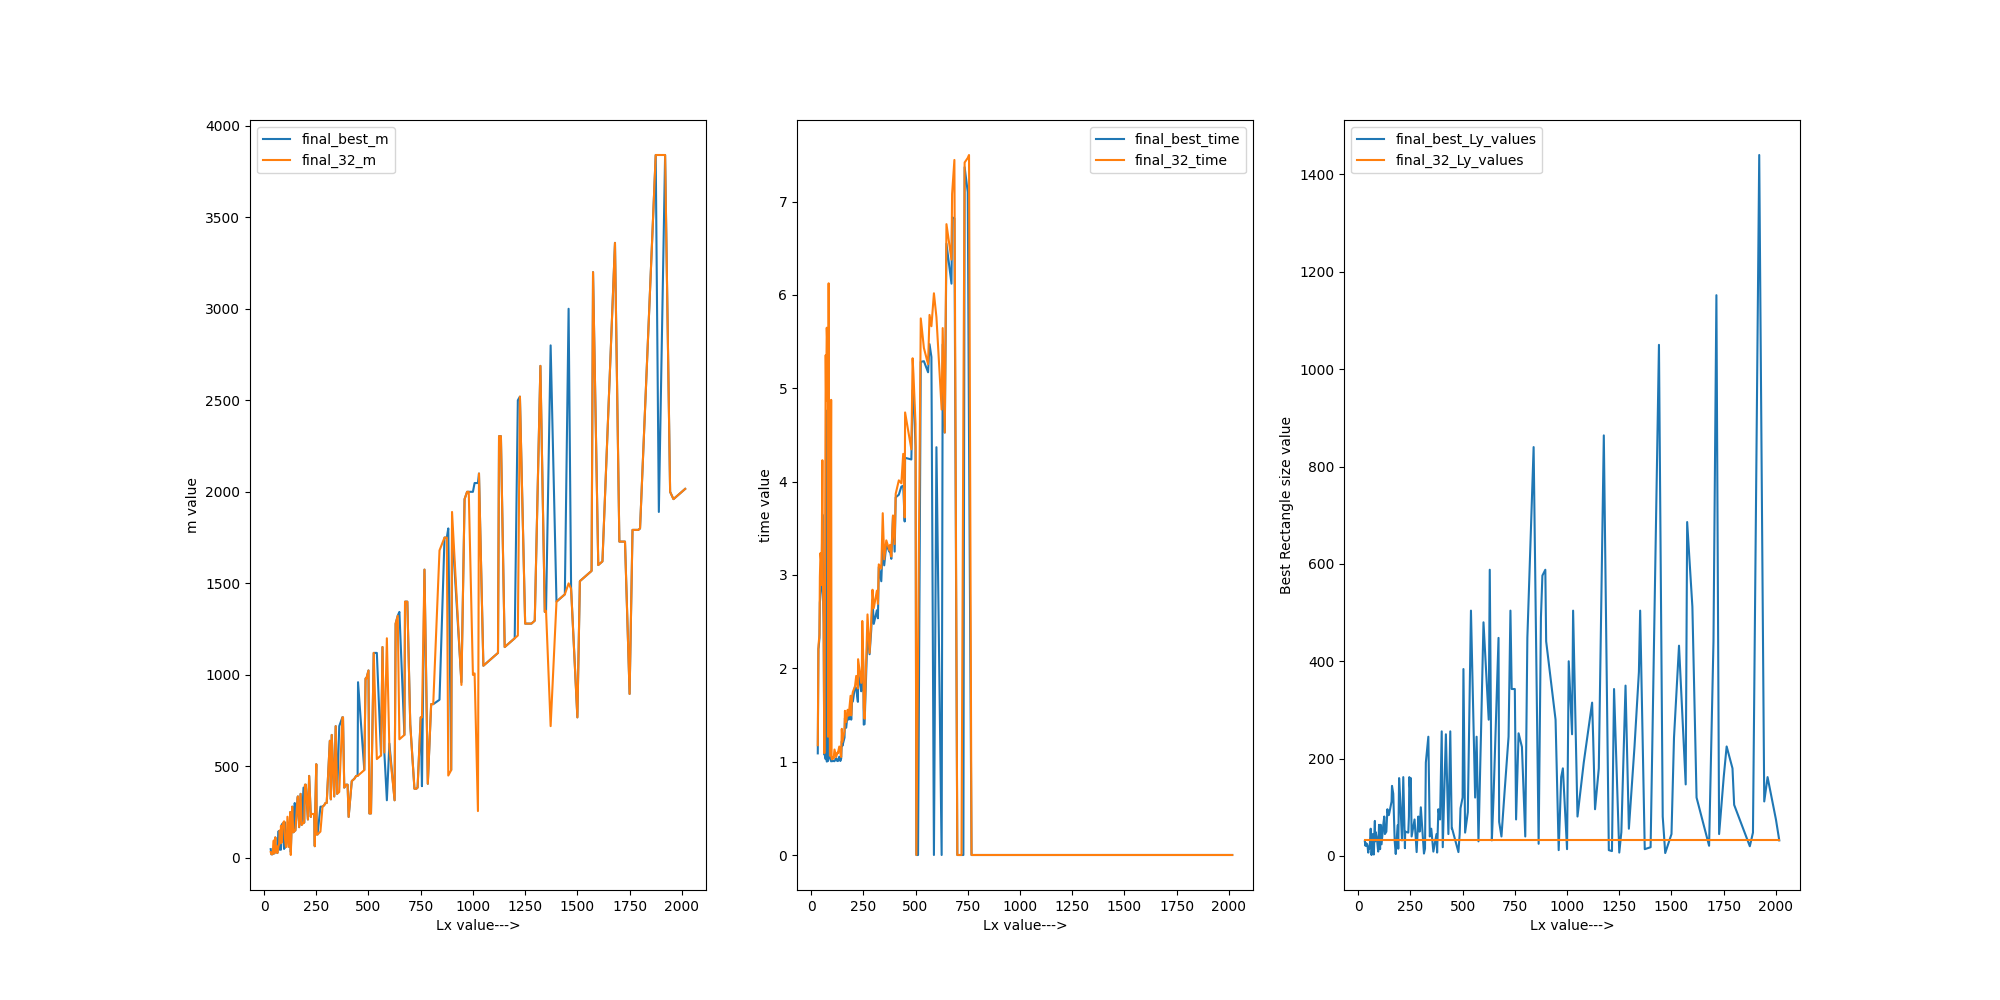

In [5]:
def optimal_values(final_m_values, final_time_values, point_to_compare = 0):
	final_set = []
	for c in range(len(final_m_values)):
		final_m, time = sort_lists(final_m_values[c], final_time_values[c], 1)
		final_set.append(final_m - point_to_compare)
	return final_set

def final_comparison(point, bound = 2048, choice = False):
	square_size  = sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = bound))[1:]
	index1 = square_size.index(point)
	if choice == True:
		range_index = input("Enter range choice")
		lower = int(range_index.split(" ")[0])
		upper = int(range_index.split(" ")[1])
	else:
		lower = index1 + 1
		upper = len(square_size)
	square_size  = sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = bound))[lower:upper]
	final_best_m = []
	final_32_m = []
	final_best_time = []
	final_32_time = []
	final_32_indices = []
	final_best_indices = []
	for i in range(len(square_size)):
		print("Square size = ", square_size[i])
		final_square_m = np.load("/home/rjoseph1/fftw++/tests/trial_runs/new_final_runs/final_square_m_values" + str(square_size[i]) + ".npy").tolist()
		final_square_time = np.load("/home/rjoseph1/fftw++/tests/trial_runs/new_final_runs/final_square_time_values" + str(square_size[i]) + ".npy").tolist()
		sorted_m = []
		sorted_time = []
		ly_values = sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = square_size[i]))[1:]
		index = ly_values.index(point)
		for j in range(len(final_square_m)):
			m, time, indices = sort_lists(final_square_m[j], final_square_time[j], 1)
			sorted_m.append(m)
			sorted_time.append(time)
		final_m, time, indices = sort_lists(sorted_m, sorted_time, 1)
		square, time2, indices1 = sort_lists(final_square_m[index], final_square_time[index], 1)
		final_best_m.append(final_m[0][0])
		final_32_m.append(square[0])
		final_best_time.append(time[0][0])
		final_32_time.append(time2[0])
		final_32_indices.append(32)
		final_best_indices.append(ly_values[indices[0]])
		print("{} Square best values".format(ly_values[indices[0]]), final_m[0], time[0])
		print("{} rectangle best values".format(square_size[index]), square, time2)
		print("----------------------------------------------------")

	# Create a figure with two subplots
	fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

	# Plot m values on the left subplot
	ax1.plot(square_size, final_best_m, label='final_best_m')
	ax1.plot(square_size, final_32_m, label='final_{}_m'.format(point))
	ax1.set_xlabel('Lx value--->')
	ax1.set_ylabel('m value')
	ax1.legend()

	# Plot time values on the right subplot
	ax2.plot(square_size, final_best_time, label='final_best_time')
	ax2.plot(square_size, final_32_time, label='final_{}_time'.format(point))
	ax2.set_xlabel('Lx value--->')
	ax2.set_ylabel('time value')
	ax2.legend()

	# Plot time values on the right subplot
	ax3.plot(square_size, final_best_indices, label='final_best_Ly_values')
	ax3.plot(square_size, final_32_indices, label='final_{}_Ly_values'.format(point))
	ax3.set_xlabel('Lx value--->')
	ax3.set_ylabel('Best Rectangle size value')
	ax3.legend()
 
 	# Show the plot
	plt.show()
	plt.savefig("final_comparison_{}.png".format(point))

final_comparison(32, 2048, False)
#final_comparison(4, 2048)

Square size =  32
[64.0, 32.0, 16.0, 27.0, 25.0, 16.0, 9.0] [4.1495e-06, 3.71325e-06, 4.843e-06, 1.51195e-05, 7.202e-06, 5.0084999999999996e-06, 8.6675e-06]
Square value is in the final m values 32.0
[1] Square best values 32.0 [3.71325e-06]
32 Square ml  values 32.0 3.71325e-06
----------------------------------------------------
Square size =  35
[75.0, 72.0, 70.0, 40.0, 36.0, 35.0, 21.0] [1.492175e-05, 1.0628250000000001e-05, 1.156475e-05, 1.32435e-05, 1.3431e-05, 1.3501e-05, 1.9365500000000003e-05]
Square value is in the final m values 72.0
[1] Square best values 72.0 [1.0628250000000001e-05]
32 Square ml  values 72.0 1.0628250000000001e-05
----------------------------------------------------
Square size =  36
[80.0, 75.0, 72.0, 42.0, 40.0, 36.0, 21.0] [1.1491e-05, 1.3715e-05, 1.1088e-05, 1.6164e-05, 1.3417e-05, 1.12095e-05, 1.9382e-05]
Square value is in the final m values 72.0
[2] Square best values 72.0 [1.1088e-05]
32 Square ml  values 72.0 1.1088e-05
--------------------------

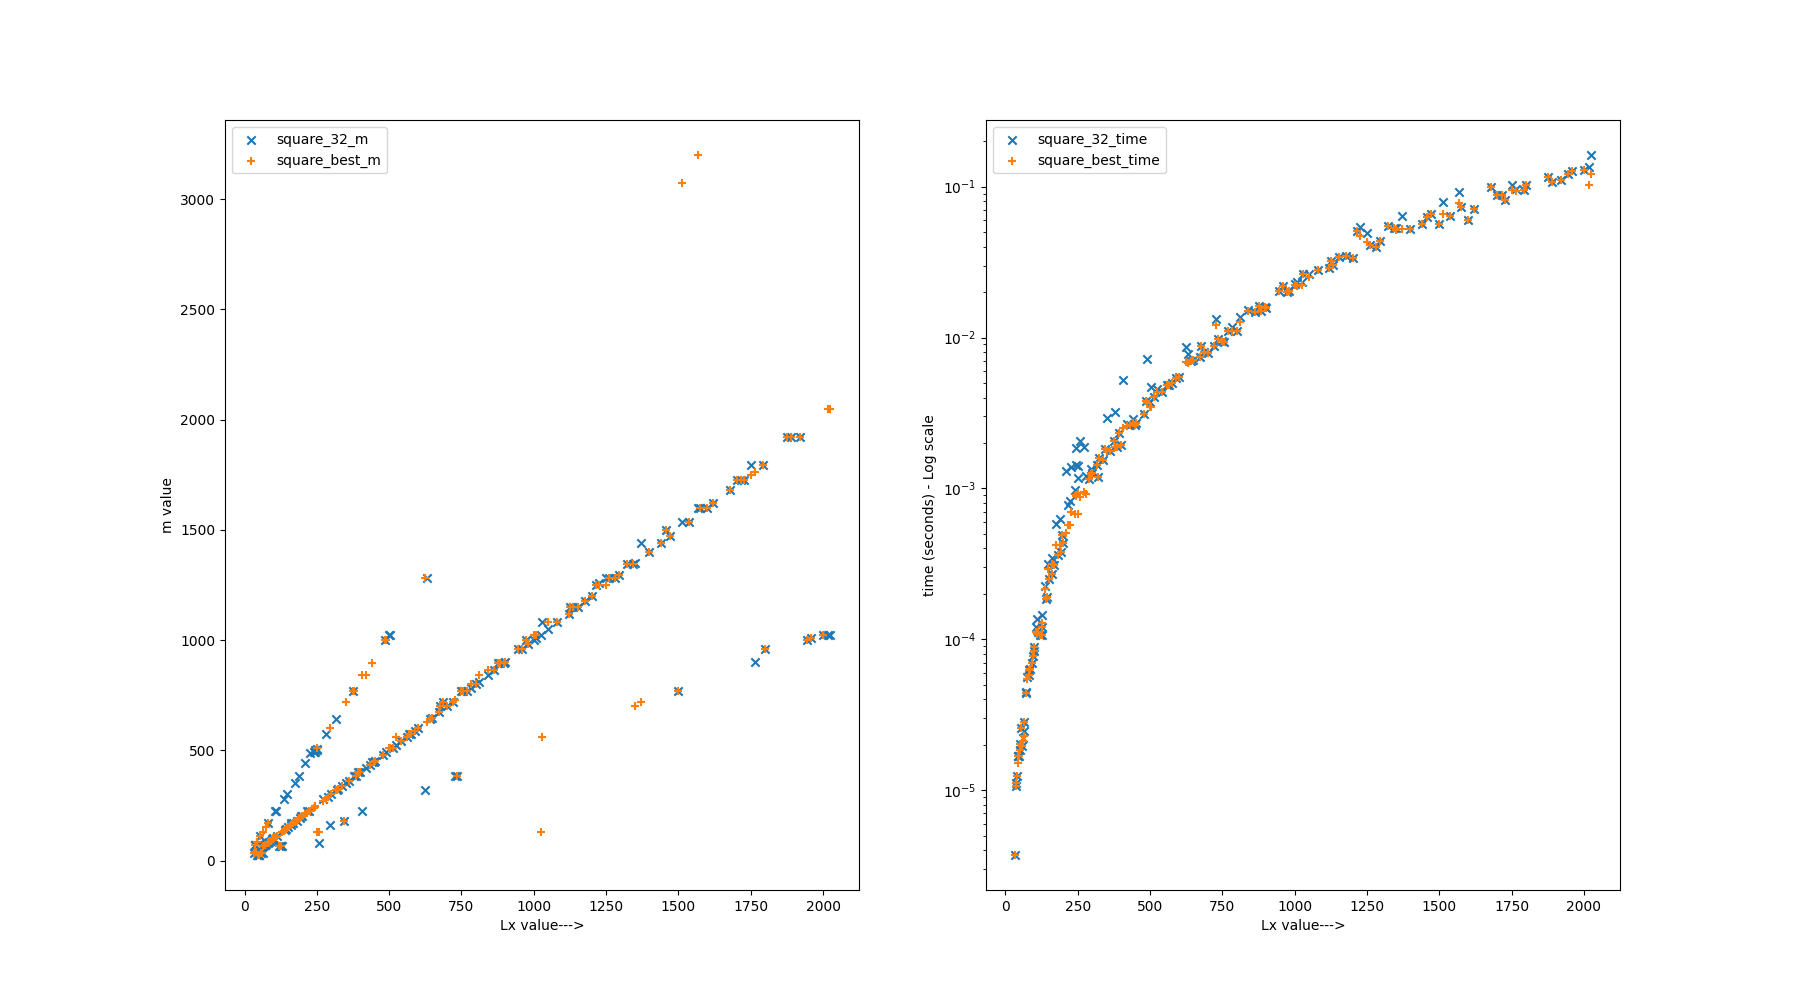

In [18]:
def optimal_values(final_m_values, final_time_values, point_to_compare = 0):
	final_set = []
	for c in range(len(final_m_values)):
		final_m, time = sort_lists(final_m_values[c], final_time_values[c], 1)
		final_set.append(final_m - point_to_compare)
	return final_set

def final_comparison(point, bound = 2048, choice = False):
	square_size  = sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = bound))[1:]
	index1 = square_size.index(point)
	if choice == True:
		range_index = input("Enter range choice")
		lower = int(range_index.split(" ")[0])
		upper = int(range_index.split(" ")[1])
	else:
		lower = index1 + 1
		upper = len(square_size)
	square_size  = sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = bound))[22:]
	final_best_m = []
	final_32_m = []
	final_best_time = []
	final_32_time = []
	final_32_indices = []
	final_best_indices = []
	square_final = []
	values = []
	square_best_m = []
	square_best_time = []
	for i in range(len(square_size)):
		print("Square size = ", square_size[i])
		final_square_m = np.load("/home/rjoseph1/fftw++/tests/trial_runs/new_runs_final/final_square_m_values" + str(square_size[i]) + ".npy").tolist()
		final_square_time = np.load("/home/rjoseph1/fftw++/tests/trial_runs/new_runs_final/final_square_time_values" + str(square_size[i]) + ".npy").tolist()
		sorted_m = []
		sorted_time = []
		ly_values = sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = square_size[i]))[1:]
		index = ly_values.index(point)
		print(final_square_m[-1], final_square_time[-1])
		final_m, time, indices = sort_lists(final_square_m[-1], final_square_time[-1], 1)
		square, time2, indices1 = sort_lists(final_square_m[index], final_square_time[index], 1)
		if square[0] in final_square_m[-1]:
			square_final.append(square_size[i])
			print("Square value is in the final m values", square[0])
			index = final_square_m[-1].index(square[0])
			time1 = final_square_time[-1][index]
			square1 = final_square_m[-1][index]
			indices = square_size[i]

			final_best_m.append(square1)
			final_32_m.append(final_m[0] )
			final_best_time.append(time1)
			final_32_time.append(time2[0])
   
			final_m, time, indices = sort_lists(final_square_m[-1], final_square_time[-1], 1)
			square_best_m.append(final_m[0])
			square_best_time.append(time[0])

			print("{} Square best values".format(indices), final_m[0], time)
			print("{} Square ml  values".format(square_size[0]), square1 , time1 )
			print("----------------------------------------------------")
			 

	square_size = square_final
	# Create a figure with two subplots
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
 
	# Plot m values on the left subplot
	#ax1.scatter(square_size, final_32_m, label='rectangle_ml_32')
	ax1.scatter(square_size, final_best_m, label='square_{}_m'.format(point), marker='x')
	ax1.scatter(square_size, square_best_m, label='square_best_m', marker = '+')
	ax1.set_xlabel('Lx value--->')
	ax1.set_ylabel('m value')
	ax1.legend()

	# Plot time values on the right subplot
	#ax2.scatter(square_size, final_32_time, label='rectangle_time_ML32')
	ax2.scatter(square_size, final_best_time, label='square_{}_time'.format(point), marker='x' )
	ax2.scatter(square_size, square_best_time, label='square_best_time', marker = '+')
	ax2.set_xlabel('Lx value--->')
	ax2.set_ylabel('time (seconds) - Log scale')
	ax2.set_yscale('log')
	ax2.legend()

 	# Show the plot
	plt.show()
	plt.savefig("final_comparison_{}.png".format(point))

final_comparison(32, 2048, False)
#final_comparison(4, 2048)

In [23]:
square_size = sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = 2048))[10:]
for i in range(len(square_size)): 	
   final_square_m = np.load("/home/rjoseph1/fftw++/tests/trial_runs/new_runs_final/final_square_m_values" + str(square_size[i]) + ".npy").tolist()
   final_square_time = np.load("/home/rjoseph1/fftw++/tests/trial_runs/new_runs_final/final_square_time_values" + str(square_size[i]) + ".npy").tolist()
   print(square_size[i], final_square_m[-1], final_square_time[-1])

12 [25.0, 24.0, 15.0, 14.0, 12.0, 7.0, 6.0] [7.460000000000001, 1.3335, 7.745, 7.43, 4.9, 9.0275, 7.824999999999999]
14 [32.0, 30.0, 28.0, 16.0, 15.0, 14.0, 7.0] [8.567499999999999, 1.8485, 1.827, 8.907499999999999, 5.2055, 7.79, 1.0575]
15 [32.0, 30.0, 16.0, 15.0, 8.0, 27.0, 25.0] [1.0915, 2.0854999999999997, 1.0485, 9.68, 1.2530000000000001, 5.0275, 2.2525000000000004]
16 [32.0, 16.0, 8.0, 27.0, 25.0, 16.0, 9.0] [4.696999999999999, 1.18425, 1.18025, 5.305, 2.21325, 1.23, 1.5190000000000001]
18 [42.0, 40.0, 36.0, 21.0, 20.0, 18.0, 9.0] [3.3725, 3.13075, 2.8255, 4.5935, 1.4785, 3.1937499999999996, 1.7045]
20 [45.0, 42.0, 40.0, 24.0, 21.0, 20.0, 14.0] [4.746, 3.8465, 3.2235, 4.575, 5.3759999999999994, 1.5775000000000001, 1.92425]
21 [48.0, 45.0, 42.0, 25.0, 24.0, 21.0, 15.0] [4.359249999999999, 5.027749999999999, 4.364750000000001, 3.23225, 4.72175, 5.2495, 2.3135]
24 [49.0, 48.0, 25.0, 24.0, 15.0, 14.0, 12.0] [6.307, 4.534, 3.4770000000000003, 4.9945, 3.1472499999999997, 3.052749999999

In [10]:
def square_optimal(square_size, threshold, epsilon):
    array3 = []
    for a in range(len(epsilon)):
        print("Epsilon = ", epsilon[a])
        print("******************************************************", end="\n")
        array2 = []
        for i in range(len(square_size)):
            print("Square size = ", square_size[i])
            final_square_m = np.load("final_square_m_values" + str(square_size[i]) + ".npy").tolist()
            final_square_time = np.load("final_square_time_values" + str(square_size[i]) + ".npy").tolist()
            final_best_square_m = np.load("final_square_m_values.npy")
            final_best_square_time = np.load("final_square_time_values.npy")
            best_m = sort_lists(final_best_square_m[i], final_best_square_time[i], 1)[0]
            array1 = []
            for j in range(2,square_size[i]):
                if shared_factors(j, square_size[i]) > threshold:
                    m = sort_lists_eps(final_square_m[j-1], final_square_time[j-1], epsilon[a])[0]
                    if best_m in m:
                        print("Ly value = ", j)
                        array1.append(j)
            if len(array1) == 0:
                print("No Ly values found.")
                array1.append(0)
            array2.append(array1)
            print("------------------------------------------------------")
        array3.append(array2)
    return array3

epsilon = [0.05]
square_size = [16,32,64,128,256,512,1024]
threshold = 2
array3 = square_optimal(non_optimal_square_size, threshold, epsilon)

Epsilon =  0.05
******************************************************
Square size =  16
Ly value =  4
------------------------------------------------------
Square size =  32
Ly value =  4
Ly value =  8
Ly value =  12
Ly value =  28
------------------------------------------------------
Square size =  64
No Ly values found.
------------------------------------------------------
Square size =  128
Ly value =  4
Ly value =  12
Ly value =  16
Ly value =  20
Ly value =  24
Ly value =  28
Ly value =  32
Ly value =  36
Ly value =  40
Ly value =  44
Ly value =  48
Ly value =  52
Ly value =  56
Ly value =  60
Ly value =  64
Ly value =  68
Ly value =  72
Ly value =  76
Ly value =  80
Ly value =  84
Ly value =  88
Ly value =  92
Ly value =  96
Ly value =  100
Ly value =  104
Ly value =  108
Ly value =  112
Ly value =  120
Ly value =  124
------------------------------------------------------
Square size =  256
Ly value =  4
Ly value =  8
Ly value =  20
Ly value =  24
Ly value =  28
Ly value =  

In [20]:
def square_optimal(square_size, threshold, epsilon, choice = 0):
    array3 = []
    for a in range(len(epsilon)):
        print("Epsilon = ", epsilon[a])
        print("******************************************************", end="\n")
        array2 = []
        array_final = []
        array_x = []
        for i in range(len(square_size)):
            print("Square size = ", square_size[i])
            if choice == 0:
                final_square_m = np.load("/home/rjoseph1/fftw++/tests/trial_runs/new_final_runs/final_square_m_values" + str(square_size[i]) + ".npy").tolist()
                final_square_time = np.load("/home/rjoseph1/fftw++/tests/trial_runs/new_final_runs/final_square_time_values" + str(square_size[i]) + ".npy").tolist()
            elif choice == 1:
                final_square_m = np.load("/home/rjoseph1/fftw++/tests/trial_runs/final_runs1/final_square_m_values" + str(square_size[i]) + ".npy").tolist()
                final_square_time = np.load("/home/rjoseph1/fftw++/tests/trial_runs/final_runs1/final_square_time_values" + str(square_size[i]) + ".npy").tolist()
            elif choice == 2:
                final_square_m = np.load("/home/rjoseph1/fftw++/tests/trial_runs/final_runs2/final_square_m_values" + str(square_size[i]) + ".npy").tolist()
                final_square_time = np.load("/home/rjoseph1/fftw++/tests/trial_runs/final_runs2/final_square_time_values" + str(square_size[i]) + ".npy").tolist()      
            best_m = sort_lists(final_square_m[-1], final_square_time[-1], 1)[0]
            array1 = []
            values_to = sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = square_size[i]))[1:]
            c = 0
            for j in values_to:
                if shared_factors(j, square_size[i]) > threshold:
                    m, n = sort_lists_eps(final_square_m[c], final_square_time[c], epsilon[a])
                    if best_m[0] in m:
                        print("Ly value = ", j)
                        array1.append(j)
                        array_final.append(array1)
                        array_x.append(square_size[i])
                c += 1
            if len(array1) == 0:
                print("No Ly values found.")
                array1.append(0)
            array2.append(array1[:1])
            print("------------------------------------------------------")
        array3.append(array2)
    return array3, array_final, array_x

# Example usage
epsilon = [0.01]
non_optimal_square_size =  sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = 2048))[2:] #list(filter(lambda x: x in multiples, values))
threshold = 2
array3, array_final, array_x = square_optimal(non_optimal_square_size, threshold, epsilon, choice = 0)

Epsilon =  0.01
******************************************************
Square size =  3
No Ly values found.
------------------------------------------------------
Square size =  4
Ly value =  4
------------------------------------------------------
Square size =  5
No Ly values found.
------------------------------------------------------
Square size =  6
Ly value =  6
------------------------------------------------------
Square size =  7
No Ly values found.
------------------------------------------------------
Square size =  8
Ly value =  4
Ly value =  8
------------------------------------------------------
Square size =  9
Ly value =  9
------------------------------------------------------
Square size =  10
Ly value =  10
------------------------------------------------------
Square size =  12
Ly value =  4
Ly value =  6
Ly value =  8
Ly value =  12
------------------------------------------------------
Square size =  14
Ly value =  14
--------------------------------------------

In [33]:
c,d = 0,0
for i in range(len(array_final)):
	if array_x[i] % array_final[i][0] == 0:
		print(array_x[i], array_final[i], "divisible")
		c += 1
	else:
		print(array_x[i], array_final[i], "not divisible")
		d +=1 
print(c, d)

8 [4] divisible
12 [4] divisible
16 [4] divisible
18 [6] divisible
20 [4] divisible
24 [4] divisible
27 [9] divisible
28 [8] not divisible
30 [6] divisible
32 [8] divisible
36 [4] divisible
40 [16] not divisible
42 [14] divisible
45 [30] not divisible
48 [4] divisible
50 [10] divisible
54 [6] divisible
56 [4] divisible
60 [4] divisible
63 [9] divisible
64 [4] divisible
70 [14] divisible
72 [6] divisible
75 [15] divisible
80 [4] divisible
81 [9] divisible
84 [6] divisible
90 [6] divisible
96 [16] divisible
98 [14] divisible
100 [4] divisible
105 [21] divisible
108 [4] divisible
112 [4] divisible
120 [4] divisible
125 [25] divisible
126 [6] divisible
128 [4] divisible
135 [9] divisible
140 [4] divisible
144 [4] divisible
147 [21] divisible
150 [6] divisible
160 [4] divisible
162 [6] divisible
168 [4] divisible
175 [25] divisible
180 [4] divisible
189 [9] divisible
192 [4] divisible
196 [4] divisible
200 [4] divisible
210 [6] divisible
216 [4] divisible
224 [4] divisible
225 [9] divisible

In [ ]:
# old code
y = array3
x = non_optimal_square_size

fig, axs = plt.subplots(2, 4, figsize=(19, 9.2), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
r = 0
for j in range(len(epsilon)):
    if j == 4:
        r = 1
    for i in range(len(non_optimal_square_size)):
        if y[j][i] == [0]:
            axs[r][j%4].scatter([x[i]]*len(y[j][i]), y[j][i], color = 'blue')
        else:
            axs[r][j%4].scatter([x[i]]*len(y[j][i]), y[j][i], label = "Epsilon = " + str(epsilon[j]), color = 'red')

    axs[r][j%4].set_xlabel('Square size --->')
    axs[r][j%4].set_ylabel('Ly value --->')
    axs[r][j%4].set_title('Epislon = ' + str(epsilon[j]) + ' and threshold = ' + str(threshold))

plt.show()

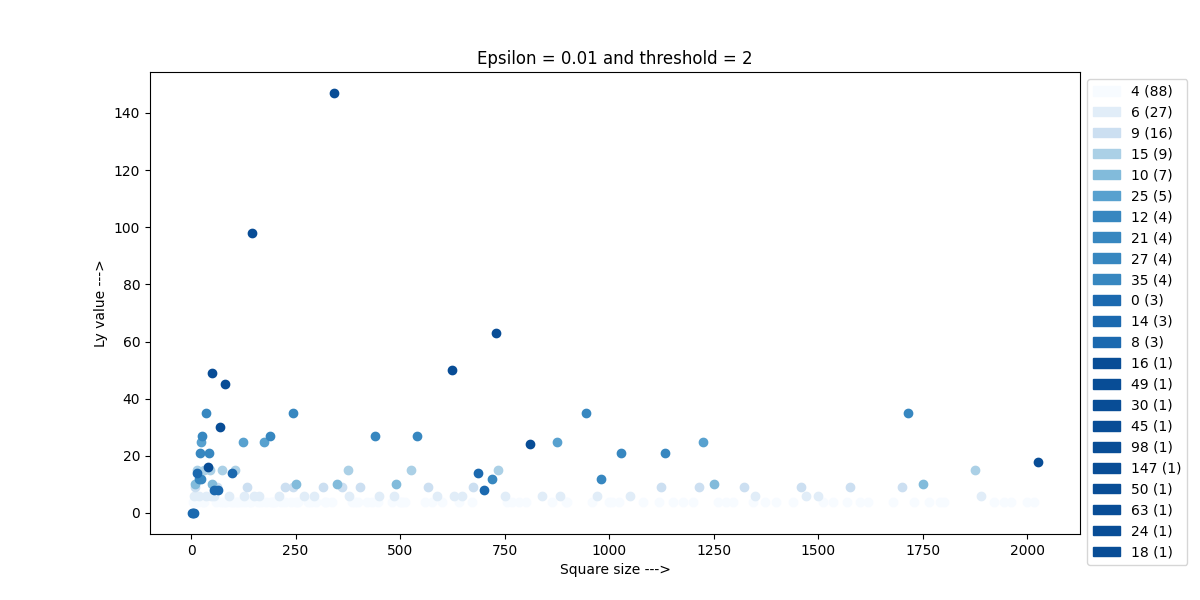

In [21]:
# plot by plot
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

y = array3
x = non_optimal_square_size
plt.figure(figsize=(12, 6))
r = 0
color_dict = {}
for j in range(len(epsilon)):
    for i in range(len(non_optimal_square_size)):
        y_value = y[j][i][0]
        if y_value in color_dict:
            color_dict[y_value].append((x[i], y_value))
        else:
            color_dict[y_value] = [(x[i], y_value)]
    count_dict = {}
    for y_value in color_dict.keys():
        count = len(color_dict[y_value])
        if count in count_dict:
            count_dict[count].append(y_value)
        else:
            count_dict[count] = [y_value]
    sorted_counts = sorted(count_dict.keys(), reverse=True)
    group_dict = {}
    color_idx = 0
    for count in sorted_counts:
        y_values = count_dict[count]
        if len(y_values) == 1:
            group_dict[y_values[0]] = cm.Blues(color_idx/len(count_dict))
            color_idx += 1
        else:
            group_color = cm.Blues(color_idx/len(count_dict))
            for y_value in y_values:
                group_dict[y_value] = group_color
            color_idx += 1
    handles = []
    for y_value in sorted(color_dict.keys(), key=lambda x: len(color_dict[x]), reverse=True):
        handles.append(mpatches.Patch(color=group_dict[y_value], label=f'{y_value} ({len(color_dict[y_value])})'))
        for point in color_dict[y_value]:
            plt.scatter([point[0]], point[1], color=group_dict[y_value])
    plt.xlabel('Square size --->')
    plt.ylabel('Ly value --->')
    plt.title('Epsilon = ' + str(epsilon[j]) + ' and threshold = ' + str(threshold))
    sm = ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=0, vmax=len(count_dict)))
    sm.set_array([])
    #plt.colorbar(sm, orientation='vertical')
    plt.legend(handles=handles, loc = 'upper left', bbox_to_anchor=(1, 1))

    plt.show()


# Machine Learning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor
import lazypredict
from lazypredict.Supervised import LazyRegressor


from sklearn.multioutput import MultiOutputRegressor

# Prediction using shape values

In [14]:
# Prepare the data
final_data = []
square_size = [i for i in range(104,904,10)]
for i in square_size:
	ly_values = [b for b in range(2,i)]
	final_m_values = np.load("/home/rjoseph1/fftw++/tests/trial_runs/new_runs/final_square_m_values" + str(i) + ".npy").tolist()
	final_time_values = np.load("/home/rjoseph1/fftw++/tests/trial_runs/new_runs/final_square_time_values" + str(i) + ".npy").tolist()
	for m in range(len(ly_values)):
		for n in range(len(final_m_values[m])):	
			final_data.append([ly_values[m], ly_values[m]*2, i, 2*i, final_m_values[m][n], final_time_values[m][n]])


In [15]:
final_data = np.array(final_data)
dataset = pd.DataFrame({'Ly': final_data[:, 0], 'My': final_data[:, 1], 'Lx': final_data[:, 2], 'Mx': final_data[:, 3], 'm': final_data[:, 4], 'time': final_data[:, 5]})

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376046 entries, 0 to 376045
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Ly      376046 non-null  float64
 1   My      376046 non-null  float64
 2   Lx      376046 non-null  float64
 3   Mx      376046 non-null  float64
 4   m       376046 non-null  float64
 5   time    376046 non-null  float64
dtypes: float64(6)
memory usage: 17.2 MB


In [ ]:
# ML part
X = dataset.drop(['m'], axis=1)
y = dataset[['m']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

reg = LazyRegressor(verbose=10, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Prediction using epsilon

In [24]:
def build(epsilon, non_optimal_square_size, array3, choice = 0):
	final = []
	for i in range(len(epsilon)):
		for j in range(len(array3[i])):
			final.append([epsilon[i], int(non_optimal_square_size[j]), 2*int(non_optimal_square_size[j])+choice, int(array3[i][j][0])])
	return np.array(final)

In [25]:
 epsilon = [0.01, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.12, 0.13, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
threshold = 2

# 1
non_optimal_square_size =  sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = 512))[2:] #list(filter(lambda x: x in multiples, values))
array3, array_final, array_x = square_optimal(non_optimal_square_size, threshold, epsilon, choice = 0)
final_data = build(epsilon, non_optimal_square_size, array3, choice = 0)
dataset = pd.DataFrame({'eps': final_data[:, 0], 'Lxy': final_data[:, 1], 'Mxy': final_data[:, 2], 'square': final_data[:, 3]})

# 2
non_optimal_square_size =  sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = 512))[2:] #list(filter(lambda x: x in multiples, values))
array3, array_final, array_x = square_optimal(non_optimal_square_size, threshold, epsilon, choice = 1)
final_data1 = build(epsilon, non_optimal_square_size, array3, choice = 1)
dataset1 = pd.DataFrame({'eps': final_data[:, 0], 'Lxy': final_data1[:, 1], 'Mxy': final_data1[:, 2], 'square': final_data[:, 3]})

# 3
non_optimal_square_size =  sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = 512))[2:] #list(filter(lambda x: x in multiples, values))
array3, array_final, array_x = square_optimal(non_optimal_square_size, threshold, epsilon, choice = 2)
final_data2 = build(epsilon, non_optimal_square_size, array3, choice = -1)
dataset2 = pd.DataFrame({'eps': final_data2[:, 0], 'Lxy': final_data2[:, 1], 'Mxy': final_data2[:, 2], 'square': final_data[:, 3]})


# 4 Combined
dataset_combined = pd.DataFrame({'eps': final_data[:, 0], 'Lxy': final_data[:, 1], 'Mxy': final_data[:, 2], 'square': final_data[:, 3], 'Mxy1': final_data1[:,2], 'square1': final_data1[:, 3], 'Mxy-1': final_data2[:,2], 'square2': final_data2[:, 3]})

Epsilon =  0.01
******************************************************
Square size =  3
No Ly values found.
------------------------------------------------------
Square size =  4
No Ly values found.
------------------------------------------------------
Square size =  5
No Ly values found.
------------------------------------------------------
Square size =  6
No Ly values found.
------------------------------------------------------
Square size =  7
No Ly values found.
------------------------------------------------------
Square size =  8
Ly value =  4
No Ly values found.
------------------------------------------------------
Square size =  9
No Ly values found.
------------------------------------------------------
Square size =  10
No Ly values found.
------------------------------------------------------
Square size =  12
Ly value =  4
Ly value =  6
Ly value =  8
No Ly values found.
------------------------------------------------------
Square size =  14
No Ly values found.
-----

In [34]:
# combine datasets
dataset_final = pd.concat([dataset, dataset1, dataset2], axis=0)

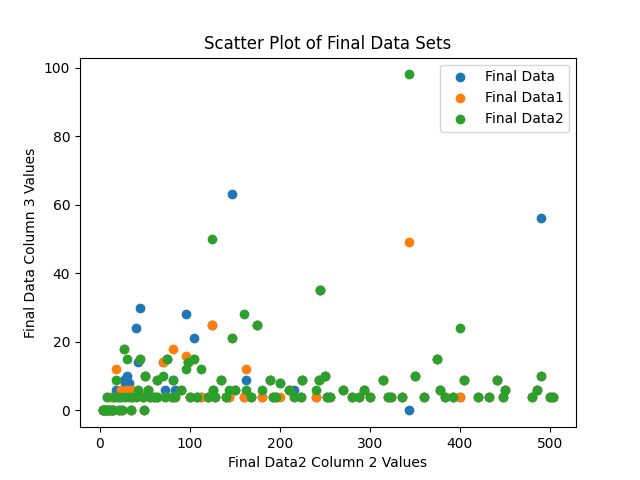

In [8]:
import matplotlib.pyplot as plt

plt.scatter(final_data2[:, 1], final_data[:, 3], label="Final Data")
plt.scatter(final_data2[:, 1], final_data1[:, 3], label="Final Data1")
plt.scatter(final_data2[:, 1], final_data2[:, 3], label="Final Data2")

plt.title("Scatter Plot of Final Data Sets")
plt.xlabel("Final Data2 Column 2 Values")
plt.ylabel("Final Data Column 3 Values")

plt.legend() # Add legend for data sets

plt.show()


# Manual Optimization

In [27]:
# ML part
X = dataset_final.drop(['square'], axis=1)
y = dataset_final[['square']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [35]:
from sklearn.model_selection import cross_val_score

ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=100,
                                       max_features=5000,     # Out of 20000
                                       random_state=0),
    "K-nn": KNeighborsRegressor(),                          # Accept default parameters
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(max_depth=100, random_state=2),
    "Decision Tree Regressor":DecisionTreeRegressor(max_depth=1000),
    "MultiO/P GBR" :MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100)),
    "MultiO/P AdaB" :MultiOutputRegressor(AdaBoostRegressor(n_estimators=100))
}

best_score = -1e5
best_estimator = None

for name, estimator in ESTIMATORS.items():
    scores = cross_val_score(estimator, X_train, y_train, cv=5)
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_estimator = estimator

print("Best estimator: {}".format(best_estimator))
print("Best cross-validation score: {}".format(best_score))
best_estimator.fit(X_train, y_train)


Best estimator: ExtraTreesRegressor(max_features=5000, random_state=0)
Best cross-validation score: 0.9876418072472303


ExtraTreesRegressor(max_features=5000, random_state=0)

In [29]:
X_test_final = X_test
y = best_estimator.predict(X_test)
X_test_final['predict'] = y[:] #- y_test['square'].astype(int).to_numpy()
#X_test_final['time_predict'] = y[:,1] - y_test['time'].to_numpy()

In [30]:
X_test_final['actual'] = y_test['square'].astype(int)
X_test_final['diff'] = X_test_final['predict'] - X_test_final['actual']

In [32]:
pd.set_option('display.max_rows', 300)
X_test_final

eps    Lxy     Mxy  predict  actual  diff
1337 0.60 500.00 1000.00    32.00      32  0.00
137  0.00  70.00  140.00     0.00       0  0.00
683  0.12 210.00  420.00     0.00       0  0.00
1201 0.50 225.00  450.00     0.64       0  0.64
758  0.13  80.00  160.00    31.68      32 -0.32
1041 0.40  16.00   32.00     0.00       0  0.00
0    0.01   3.00    6.00     0.00       0  0.00
1574 0.90  54.00  108.00     0.32       0  0.32
968  0.30  96.00  192.00    14.40       0 14.40
1018 0.30 400.00  800.00    32.00      32  0.00
691  0.12 252.00  504.00    32.00      32  0.00
1205 0.50 250.00  500.00     0.32       0  0.32
868  0.20 105.00  210.00     0.00       0  0.00
467  0.05 150.00  300.00     0.64       0  0.64
836  0.20  18.00   36.00     0.00       0  0.00
803  0.13 324.00  648.00    32.00      32  0.00
1313 0.60 288.00  576.00    32.00      32  0.00
360  0.01 135.00  270.00     0.00       0  0.00
1168 0.50  72.00  144.00    32.00      32  0.00
1640 0.90 441.00  882.00     1.60       0  1.60
601  0.10 360.00  720.00    31.68      32 -0.32
1208 0.50 270.00  540.00     0.32       0  0.32
421  0.05  14.00   28.00     0.00       0  0.00
981  0.30 147.00  294.00     0.00       0  0.00
1110 0.40 315.00  630.00     0.00       0  0.00
743  0.13  36.00   72.00     0.00       0  0.00
1267 0.60  60.00  120.00    32.00      32  0.00
563  0.10 125.00  250.00     0.00       0  0.00
721  0.13   3.00    6.00     0.00       0  0.00
910  0.20 360.00  720.00    32.00      32  0.00
835  0.20  16.00   32.00     0.00       0  0.00
184  0.00 320.00  640.00    32.00      32  0.00
848  0.20  42.00   84.00     0.00       0  0.00
997  0.30 243.00  486.00     0.32       0  0.32
100  0.01 490.00  980.00     0.00       0  0.00
60   0.01 180.00  360.00    32.00      32  0.00
653  0.12  72.00  144.00    32.00      32  0.00
475  0.05 196.00  392.00    32.00      32  0.00
640  0.12  36.00   72.00     0.00       0  0.00
714  0.12 448.00  896.00    32.00      32  0.00
766  0.13 108.00  216.00    32.00      32  0.00
1482 0.80  90.00  180.00     0.32       0  0.32
225  0.00  30.00   60.00     0.00       0  0.00
665  0.12 120.00  240.00    32.00      32  0.00
256  0.00 128.00  256.00     3.52       0  3.52
707  0.12 384.00  768.00    32.00      32  0.00
90   0.01 392.00  784.00    32.00      32  0.00
784  0.13 196.00  392.00    32.00      32  0.00
1536 0.80 432.00  864.00    32.00      32  0.00
559  0.10 105.00  210.00     0.00       0  0.00
621  0.12   6.00   12.00     0.00       0  0.00
869  0.20 108.00  216.00    32.00      32  0.00
693  0.12 270.00  540.00     0.00       0  0.00
1633 0.90 378.00  756.00     0.32       0  0.32
1403 0.70 200.00  400.00    32.00      32  0.00
783  0.13 192.00  384.00    32.00      32  0.00
1457 0.80  24.00   48.00     0.00       0  0.00
336  0.01  49.00   98.00     0.00       0  0.00
1358 0.70  30.00   60.00     0.00       0  0.00
379  0.01 243.00  486.00     0.00       0  0.00
1560 0.90  24.00   48.00     0.00       0  0.00
531  0.10  25.00   50.00     0.00       0  0.00
1590 0.90 108.00  216.00    32.00      32  0.00
1545 0.90   3.00    6.00     0.00       0  0.00
1315 0.60 300.00  600.00    31.68      32 -0.32
353  0.01 105.00  210.00     2.24       0  2.24
509  0.05 450.00  900.00     0.00       0  0.00
1611 0.90 216.00  432.00    31.36      32 -0.64
218  0.00  18.00   36.00     0.00       0  0.00
224  0.00  28.00   56.00     0.00       0  0.00
198  0.00 441.00  882.00     0.00       0  0.00
89   0.01 384.00  768.00    32.00      32  0.00
614  0.10 486.00  972.00     0.00       0  0.00
1562 0.90  27.00   54.00     0.00       0  0.00
862  0.20  81.00  162.00     0.32       0  0.32
346  0.01  80.00  160.00    32.00      32  0.00
619  0.12   4.00    8.00     0.00       0  0.00
915  0.20 400.00  800.00    32.00      32  0.00
722  0.13   4.00    8.00     0.00       0  0.00
534  0.10  30.00   60.00     0.00       0  0.00
1501 0.80 175.00  350.00     0.64       0  0.64
857  0.20  64.00  128.00     0.00       0  0.00
1200 0.50 224.00  448.

# Now checking for OOD

In [84]:
epsilon = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.12, 0.13, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
non_optimal_square_size =  [i for i in range(128, 155)]
threshold = 2
array3, array_final, array_x = square_optimal(non_optimal_square_size, threshold, epsilon, choice = 0)

final = []
for i in range(len(epsilon)):
	for j in range(len(array3[i])):
		final.append([epsilon[i], int(non_optimal_square_size[j]), 2*int(non_optimal_square_size[j]), int(array3[i][j][0])])
final_data = np.array(final)
dataset = pd.DataFrame({'eps': final_data[:, 0], 'Lxy': final_data[:, 1], 'Mxy': final_data[:, 2], 'square': final_data[:, 3]})
X_test1, y_test1 = dataset.drop(['square'], axis=1), dataset[['square']]
y = best_estimator.predict(X_test1)
print("Score ", best_estimator.score(X_test1, y_test1))
X_test1['predict'] = y[:] #- y_test['square'].astype(int).to_numpy()
X_test1['actual'] = y_test1['square'].astype(int)
X_test1['diff'] = X_test1['predict'] - X_test1['actual']
X_test1

Epsilon =  0.0001
******************************************************
Square size =  128
Ly value =  4
Ly value =  12
Ly value =  16
Ly value =  20
Ly value =  24
Ly value =  28
Ly value =  40
Ly value =  48
Ly value =  56
Ly value =  60
Ly value =  64
Ly value =  72
Ly value =  80
Ly value =  84
Ly value =  100
Ly value =  108
Ly value =  112
Ly value =  120
------------------------------------------------------
Square size =  129
No Ly values found.
------------------------------------------------------
Square size =  130
Ly value =  10
Ly value =  20
Ly value =  30
Ly value =  40
Ly value =  50
Ly value =  60
Ly value =  70
Ly value =  80
Ly value =  90
Ly value =  100
Ly value =  120
------------------------------------------------------
Square size =  131
No Ly values found.
------------------------------------------------------
Square size =  132
Ly value =  4
Ly value =  6
Ly value =  8
Ly value =  12
Ly value =  16
Ly value =  18
Ly value =  20
Ly value =  24
Ly value =  28


eps    Lxy    Mxy  predict  actual  diff
0   0.00 128.00 256.00     4.00       4  0.00
1   0.00 129.00 258.00     4.00       0  4.00
2   0.00 130.00 260.00     4.00      10 -6.00
3   0.00 131.00 262.00     4.00       0  4.00
4   0.00 132.00 264.00     9.00       4  5.00
..   ...    ...    ...      ...     ...   ...
400 0.90 150.00 300.00     6.00       6  0.00
401 0.90 151.00 302.00     6.00       0  6.00
402 0.90 152.00 304.00     6.00       4  2.00
403 0.90 153.00 306.00     6.00       9 -3.00
404 0.90 154.00 308.00     6.00      14 -8.00

[405 rows x 6 columns]

# Check for 2,3,5,7

In [36]:
epsilon = [0.0001, 0.001, 0.01]
non_optimal_square_size =  sorted(generate_multiples(a_max=10, b_max=10, c_max=10, d_max=10, bound = 2300))[187:]
threshold = 2
array3, array_final, array_x = square_optimal(non_optimal_square_size, threshold, epsilon, choice = 0)

final = []
for i in range(len(epsilon)):
	for j in range(len(array3[i])):
		final.append([epsilon[i], int(non_optimal_square_size[j]), 2*int(non_optimal_square_size[j]), int(array3[i][j][0])])
final_data = np.array(final)
dataset = pd.DataFrame({'eps': final_data[:, 0], 'Lxy': final_data[:, 1], 'Mxy': final_data[:, 2], 'square': final_data[:, 3]})
X_test1, y_test1 = dataset.drop(['square'], axis=1), dataset[['square']]
y = best_estimator.predict(X_test1)
print("Score ", best_estimator.score(X_test1, y_test1))
X_test1['predict'] = y[:] #- y_test['square'].astype(int).to_numpy()
X_test1['actual'] = y_test1['square'].astype(int)
X_test1['diff'] = X_test1['predict'] - X_test1['actual']
X_test1

Epsilon =  0.0001
******************************************************
Square size =  2016
Ly value =  12
Ly value =  70
Ly value =  72
Ly value =  100
Ly value =  108
Ly value =  160
Ly value =  168
Ly value =  196
Ly value =  210
Ly value =  270
Ly value =  384
Ly value =  450
Ly value =  504
Ly value =  512
Ly value =  525
Ly value =  540
Ly value =  588
Ly value =  648
Ly value =  686
Ly value =  720
Ly value =  729
Ly value =  750
Ly value =  768
Ly value =  784
Ly value =  810
Ly value =  960
Ly value =  972
Ly value =  1000
Ly value =  1125
Ly value =  1215
Ly value =  1260
Ly value =  1280
Ly value =  1323
Ly value =  1350
Ly value =  1440
Ly value =  1470
Ly value =  1568
Ly value =  1600
Ly value =  1620
No Ly values found.
------------------------------------------------------
Square size =  2025
Ly value =  15
Ly value =  18
Ly value =  25
Ly value =  27
Ly value =  30
Ly value =  36
Ly value =  45
Ly value =  54
Ly value =  60
Ly value =  63
Ly value =  72
Ly value =  75

eps     Lxy     Mxy  predict  actual  diff
0  0.00 2016.00 4032.00    32.00       0 32.00
1  0.00 2025.00 4050.00    32.00       0 32.00
2  0.00 2058.00 4116.00    32.00       0 32.00
3  0.00 2100.00 4200.00    32.00      32  0.00
4  0.00 2160.00 4320.00    32.00      32  0.00
5  0.00 2187.00 4374.00    32.00       0 32.00
6  0.00 2205.00 4410.00    32.00       0 32.00
7  0.00 2240.00 4480.00    32.00      32  0.00
8  0.00 2250.00 4500.00    32.00       0 32.00
9  0.00 2268.00 4536.00    32.00      32  0.00
10 0.00 2016.00 4032.00    32.00       0 32.00
11 0.00 2025.00 4050.00    32.00       0 32.00
12 0.00 2058.00 4116.00    32.00       0 32.00
13 0.00 2100.00 4200.00    32.00      32  0.00
14 0.00 2160.00 4320.00    32.00      32  0.00
15 0.00 2187.00 4374.00    32.00       0 32.00
16 0.00 2205.00 4410.00    32.00       0 32.00
17 0.00 2240.00 4480.00    32.00      32  0.00
18 0.00 2250.00 4500.00    32.00       0 32.00
19 0.00 2268.00 4536.00    32.00      32  0.00
20 0.01 2016.00 4032.00    32.00       0 32.00
21 0.01 2025.00 4050.00    32.00       0 32.00
22 0.01 2058.00 4116.00    32.00       0 32.00
23 0.01 2100.00 4200.00    32.00      32  0.00
24 0.01 2160.00 4320.00    32.00      32  0.00
25 0.01 2187.00 4374.00    32.00       0 32.00
26 0.01 2205.00 4410.00    32.00       0 32.00
27 0.01 2240.00 4480.00    32.00      32  0.00
28 0.01 2250.00 4500.00    32.00       0 32.00
29 0.01 2268.00 4536.00    32.00      32  0.00